In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu, kruskal, pearsonr, spearmanr

import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [57]:
df = pd.read_csv("Data/final_data.csv")
df["date"] = pd.to_datetime(df["date"])

## Príprava dát

Pôvodné dáta obsahovali záznamy z viacerých cyklosčítačov na hodinovej báze. Pre účely tejto analýzy boli dáta agregované na dennú úroveň pre celé mesto Bratislava.

Na zabezpečenie reprodukovateľnosti výsledkov boli fixované náhodné seed-y pri rozdelení dát aj pri trénovaní modelov.

In [58]:
df[["prcp","tavg","tsun","wpgt"]].describe()

,prcp,tavg,tsun,wpgt
count,458870.000000,458870.000000,337097.000000,458870.000000
mean,1.656176,12.855927,270.034358,30.150411
std,4.179353,8.016305,212.018349,8.687983
min,0.000000,-5.700000,0.000000,11.100000
25%,0.000000,6.100000,82.000000,24.100000
50%,0.000000,12.600000,241.000000,29.600000
75%,0.900000,19.400000,422.000000,35.200000
max,37.300000,28.900000,792.000000,72.200000


In [59]:
stats = df[["prcp","tavg","tsun","wpgt"]].describe().T

stats = stats[["mean", "std", "min", "max"]]

stats = stats.round(2)

print(stats)


        mean     std   min    max
prcp    1.66    4.18   0.0   37.3
tavg   12.86    8.02  -5.7   28.9
tsun  270.03  212.02   0.0  792.0
wpgt   30.15    8.69  11.1   72.2


In [60]:
daily_data = df.groupby("date", as_index=False).agg(
    daily_cyclists=("pocet_total", "sum"),
    prcp=("prcp", "sum"),
    tavg=("tavg", "mean"),
    tsun=("tsun", "sum"),
    wpgt=("wpgt", "max"),
    is_weekend=("is_weekend", "first")
)

X = daily_data[["prcp", "tavg", "tsun", "wpgt", "is_weekend"]]
y = daily_data["daily_cyclists"]


In [61]:
# Škálovanie
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [62]:
# Ridge regresia
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Lasso regresia
lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=10000, random_state=42)

In [63]:
# Tabuľka koeficientov
collumn_names = {
    "prcp": "Denné zrážky (mm)",
    "tavg": "Priemerná denná teplota (°C)",
    "tsun": "Dĺžka slnečného svitu",
    "wpgt": "Maximálny náraz vetra",
    "is_weekend": "Víkend (1 = áno)"
}

coef_table = pd.DataFrame({
    "Premenná": [collumn_names[col] for col in X.columns],
    "Ridge koeficient": ridge.coef_,
    "Lasso koeficient": lasso.coef_
})

# zaokrúhlenie
coef_table[["Ridge koeficient", "Lasso koeficient"]] = (
    coef_table[["Ridge koeficient", "Lasso koeficient"]].round(2)
)

# výsledky
print("\nTabuľka koeficientov Ridge a Lasso regresie:")
print(coef_table)


Tabuľka koeficientov Ridge a Lasso regresie:
                       Premenná  Ridge koeficient  Lasso koeficient
0             Denné zrážky (mm)           -913.17           -914.26
1  Priemerná denná teplota (°C)           4295.56           4300.49
2         Dĺžka slnečného svitu           1380.15           1380.00
3         Maximálny náraz vetra           -599.91           -600.23
4              Víkend (1 = áno)            702.71            703.48


Štatistické testy


In [64]:
daily_data["weekday"] = daily_data["date"].dt.weekday
daily_data["month"] = daily_data["date"].dt.month
daily_data["season"] = pd.cut(daily_data["month"],
                               bins=[0,3,6,9,12],
                               labels=["winter","spring","summer","autumn"],
                               right=True)



--- Pracovné dni vs víkendy ---
Mann–Whitney U stat: 108529.5, p-value: 0.012895


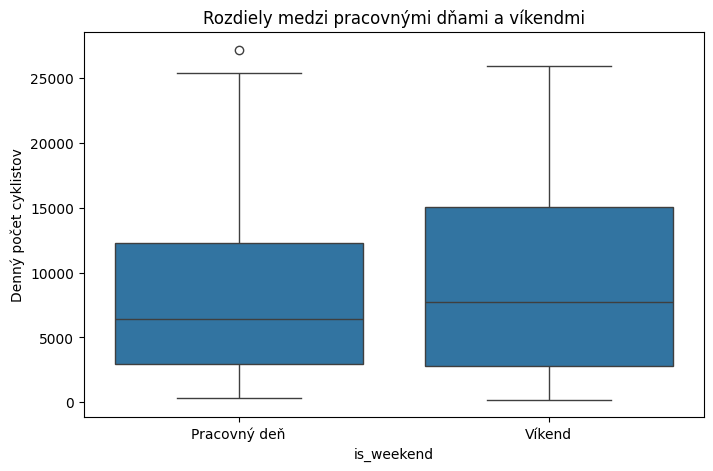

In [65]:
# Pracovné dni vs víkendy
print("\n--- Pracovné dni vs víkendy ---")
workday = daily_data[daily_data["is_weekend"] == 0]["daily_cyclists"]
weekend = daily_data[daily_data["is_weekend"] == 1]["daily_cyclists"]

# Mann–Whitney U test
stat, p = mannwhitneyu(workday, weekend, alternative='two-sided')
print(f"Mann–Whitney U stat: {stat}, p-value: {p:.6f}")

# Vizualizácia Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x="is_weekend", y="daily_cyclists", data=daily_data)
plt.xticks([0,1], ["Pracovný deň", "Víkend"])
plt.ylabel("Denný počet cyklistov")
plt.title("Rozdiely medzi pracovnými dňami a víkendmi")
plt.show()



--- Vplyv zrážok ---
Pearson r: -0.197, p-value: 0.000000
Spearman rho: -0.297, p-value: 0.000000


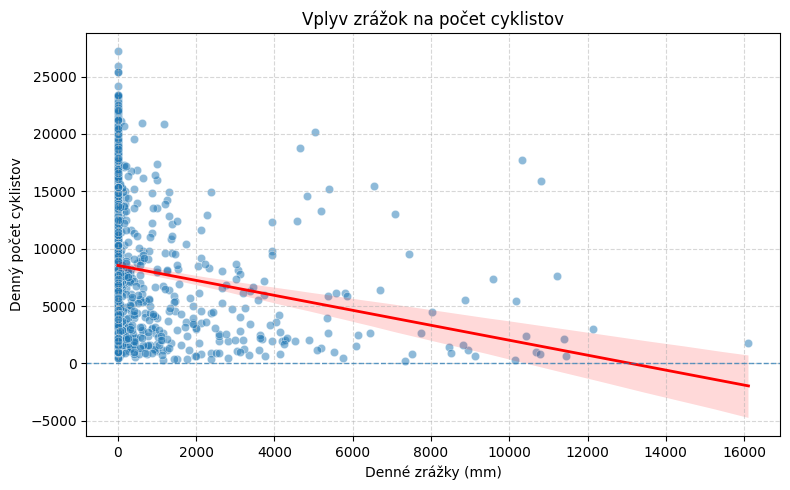

In [66]:
# Vplyv zrážok
print("\n--- Vplyv zrážok ---")
# Korelácia Pearson a Spearman
pearson_r, pearson_p = pearsonr(daily_data["prcp"], daily_data["daily_cyclists"])
spearman_r, spearman_p = spearmanr(daily_data["prcp"], daily_data["daily_cyclists"])

print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.6f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.6f}")

# Scatter plot s regresnou čiarou
plt.figure(figsize=(8,5))

sns.scatterplot(
    x="prcp",
    y="daily_cyclists",
    data=daily_data,
    alpha=0.5
)

sns.regplot(
    x="prcp",
    y="daily_cyclists",
    data=daily_data,
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

# čiara pre y = 0 (dolná hranica počtu cyklistov)
plt.axhline(0, linestyle="--", linewidth=1, alpha=0.7)

# mriežka
plt.grid(True, linestyle="--", alpha=0.5)

plt.xlabel("Denné zrážky (mm)")
plt.ylabel("Denný počet cyklistov")
plt.title("Vplyv zrážok na počet cyklistov")

plt.tight_layout()
plt.show()
